In [1]:
%pip uninstall torch torch_geometric pyg-lib torch-sparse -y
# 2.1 PyTorch (CPU) – подмените индекс, если нужна CUDA
%pip install torch==2.4.0 torchvision torchaudio

# 2.2 PyG: с 2.3+ внешних библиотек почти нет, ставим одной строкой
%pip install torch_geometric 
%pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


# 2.4 остальное
%pip install xgboost pandas matplotlib graphviz scikit-learn tqdm numpy networkx seaborn rdkit


Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Found existing installation: pyg-lib 0.4.0+pt24
Uninstalling pyg-lib-0.4.0+pt24:
  Successfully uninstalled pyg-lib-0.4.0+pt24
Found existing installation: torch_sparse 0.6.18
Uninstalling torch_sparse-0.6.18:
  Successfully uninstalled torch_sparse-0.6.18
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.4.0-cp38-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.4.0-cp38-none-macosx_11_0_arm64.whl (62.1 MB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-non

In [2]:
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import to_undirected
import math

print(torch.__version__)

/Users/a1234/Fraud/.venv/lib/python3.8/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/a1234/Fraud/.venv/lib/python3.8/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.8/Python
  Referenced from: <FC2050EE-717A-3D68-82A8-EA7E2DF7A741> /Users/a1234/Fraud/.venv/lib/python3.8/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.8/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.8/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.8/Python' (no such file)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/Users/a1234/Fraud/.venv/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/a1234/Fraud/

2.4.0


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Чтение датасета

In [4]:
from pathlib import Path
ACCOUNTS_CSV = Path('./tmp/Ethereum/account.csv')      # обновите при необходимости
TXS_CSV      = Path('./tmp/Ethereum/transaction.csv')   # обновите при необходимости

assert ACCOUNTS_CSV.exists(), f'{ACCOUNTS_CSV} not found'
assert TXS_CSV.exists(), f'{TXS_CSV} not found'

In [5]:
acc_df = pd.read_csv(ACCOUNTS_CSV, header=None, names=['id', 'label'])
tx_df  = pd.read_csv(TXS_CSV, header=None, names=['src', 'dst', 'amount', 'timestamp'])

display(acc_df.head())
display(tx_df.head())

,id,label
0,0x8335392fe1b236296c5d5f653264396de165e46c,True
1,0x9d4b62503b4b7993182323effe6245f6d77e4413,True
2,0xc91293245b669da19a96cd85d40bb9c203359657,True
3,0x1056d8d9ebb0e0d8710a0e2a1852d4a09d56464a,True
4,0x4f1872383be22878af5d4795b69be61b35ec5d10,True


,src,dst,amount,timestamp
0,0x21f74c6bbc1e3ab9f0205e12de3a9daa14351aed,0x46f1c0481803cb34a7860d614b5430c5db51bfb7,5.00000,1.502740e+09
1,0x54008c2684d96c44a094dc127842ec144b157e96,0x1acee83486b6671b005eed45c9fb9277e7eeb63d,2.34758,1.518731e+09
2,0x97aeb9b292c00405e145d9c7a8429bc970fa0e65,0x4f00b95c625c6d6ef72748d78c750fd6c84a8b85,0.01003,1.516224e+09
3,0x2dfdf31bbc29468d487591f292872a14c1f8d1f0,0x474057adf42f9f955e86aa1142740f9d7763e41e,0.51587,1.522422e+09
4,0x5b39067ee0309856edd13f23c9c1793f9fda1b4f,0x6376baf58c4c5d70ba8fca9565b6955f07c584a9,6.67000,1.514817e+09


## 🏗️ Сборка графа

In [6]:
G = nx.DiGraph()

# add nodes
for _, row in acc_df.iterrows():
    G.add_node(row.id, label=int(bool(row.label)))

# add edges
for _, row in tx_df.iterrows():
    G.add_edge(row.src, row.dst, amount=float(row.amount), ts=float(row.timestamp))

print(f'Граф содержит {G.number_of_nodes():,} узлов и {G.number_of_edges():,} рёбер')

Граф содержит 32,168 узлов и 42,044 рёбер


In [7]:
# Структурные признаки
in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())

# Финансовые суммы
sent_sum = {n: 0.0 for n in G.nodes()}
recv_sum = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    amt = d['amount']
    sent_sum[u] += amt
    recv_sum[v] += amt

# PageRank и кластерный коэффициент
pr = nx.pagerank(G, alpha=0.85)
clust = nx.clustering(G.to_undirected())

# Записываем фичи в граф
for n in G.nodes():
    G.nodes[n].update({
        'in_deg':      in_deg.get(n, 0),
        'out_deg':     out_deg.get(n, 0),
        'sent_sum':    sent_sum[n],
        'recv_sum':    recv_sum[n],
        'net_sum':     sent_sum[n] - recv_sum[n],
        'pagerank':    pr[n],
        'clustering':  clust[n],
    })

# --- после расчёта pr и clust --------------------------------------------
print('⏳ Calculating extra graph features…')

# 1) Betweenness (approx)
btw = nx.betweenness_centrality(G, k=10_000, seed=42, normalized=True)

# 2) Weakly-connected component size
G_u = G.to_undirected()
wcc = {n: 0 for n in G}
for comp in nx.connected_components(G_u):
    size = len(comp)
    for n in comp:
        wcc[n] = size

# 3) Min amounts
send_min = {n: math.inf for n in G}
recv_min = {n: math.inf for n in G}
for u, v, d in G.edges(data=True):
    amt = d['amount']
    send_min[u] = min(send_min[u], amt)
    recv_min[v] = min(recv_min[v], amt)
# заменяем inf → 0.0 (узлы без операций)
send_min = {n: 0.0 if math.isinf(v) else v for n, v in send_min.items()}
recv_min = {n: 0.0 if math.isinf(v) else v for n, v in recv_min.items()}

# --- записываем все новые фичи в вершины ----------------------------------
for n in G.nodes():
    G.nodes[n].update({
        'btw_centr':   btw[n],
        'wcc_size':    wcc[n],
        'send_min':    send_min[n],
        'recv_min':    recv_min[n],
    })

⏳ Calculating extra graph features…


In [8]:
 # --- перед обучением Node2Vec: создаём маппинг id → idx -------------------
id2idx = {n: i for i, n in enumerate(G.nodes())}

# --- строим edge_index по числовым индексам ------------------------------
edges = list(G.edges())
row = [id2idx[u] for u, v in edges]
col = [id2idx[v] for u, v in edges]
edge_index = torch.tensor([row, col], dtype=torch.long)
edge_index = to_undirected(edge_index).contiguous()

# --- теперь обучаем Node2Vec на неориентированном графе --------------------
print('⏳ Training Node2Vec…')
n2v = Node2Vec(
    edge_index=edge_index,
    num_nodes=G.number_of_nodes(),
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=5,
    num_negative_samples=1,
    sparse=True,
    p=1, q=1
).to(device)

loader = n2v.loader(batch_size=1024, shuffle=True)
opt = torch.optim.SparseAdam(list(n2v.parameters()), lr=0.01)

n2v.train()
for epoch in range(1):  # можете увеличить число эпох
    total_loss = 0
    for pos_rw, neg_rw in loader:
        opt.zero_grad()
        loss = n2v.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss {total_loss:.4f}')

⏳ Training Node2Vec…
Epoch 1, Loss 245.9309


In [9]:
# --- извлекаем эмбеддинги и записываем обратно в G ------------------------
z = n2v.embedding.weight.detach().cpu()
for n, idx in id2idx.items():
    G.nodes[n]['n2v'] = z[idx]

# --- при формировании data.x ---------------------------------------------
num_attr_keys = [
    'in_deg','out_deg','sent_sum','recv_sum','net_sum',
    'pagerank','clustering',
    'btw_centr','wcc_size','send_min','recv_min'
]

for n in G.nodes():
    base = [float(G.nodes[n][k]) for k in num_attr_keys]
    emb  = G.nodes[n]['n2v'].tolist()           # 128-мерный
    G.nodes[n]['x'] = torch.tensor(base + emb, dtype=torch.float)

print('Пример фич узла:', list(G.nodes(data=True))[0])

Пример фич узла: ('0x8335392fe1b236296c5d5f653264396de165e46c', {'label': 1, 'in_deg': 4, 'out_deg': 1, 'sent_sum': 3.49954, 'recv_sum': 3.4999599999999997, 'net_sum': -0.0004199999999996429, 'pagerank': 4.475874254314406e-05, 'clustering': 0, 'btw_centr': 0.0, 'wcc_size': 30701, 'send_min': 3.49954, 'recv_min': 0.5, 'n2v': tensor([ 6.8942e-01,  8.5973e-01,  1.0686e+00,  1.4085e+00,  1.0570e+00,
        -1.4657e+00, -1.3695e-01,  1.0924e+00,  1.0840e+00,  7.2765e-01,
         1.1007e+00,  4.2189e-01, -1.0614e-02,  8.4886e-01,  8.8466e-03,
         3.1550e-01,  2.9505e+00,  8.3457e-01, -1.3613e+00, -2.7187e-01,
         1.1702e+00,  6.5422e-01,  1.1230e+00,  9.5035e-01, -4.9182e-01,
        -1.0446e-01, -1.2157e+00, -3.3540e-01, -9.3921e-03,  9.2506e-01,
         1.0898e-01,  2.1533e-01, -1.1534e-01, -6.5742e-01, -3.7616e-01,
        -6.1318e-01,  4.2779e-02,  1.8825e-01,  7.5775e-01, -4.5954e-01,
         3.8189e-01, -1.6699e-01, -5.5390e-01, -1.9875e+00, -5.5424e-01,
         9.2062e-

In [10]:
# 🔧 Делаем так, чтобы у всех узлов была метка
nx.set_node_attributes(G, -1, "label")        # сначала всем ставим -1
for _, row in acc_df.iterrows():              # затем переопределяем тем, что есть в accounts.csv
    G.nodes[row.id]["label"] = int(bool(row.label))   

In [11]:
# после формирования всех численных признаков, до отправки в PyG
from sklearn.preprocessing import StandardScaler
X = np.stack([G.nodes[n]['x'].numpy() for n in G.nodes()])
scaler = StandardScaler()
X = scaler.fit_transform(X)
for n, vec in zip(G.nodes(), X):
    G.nodes[n]['x'] = torch.tensor(vec, dtype=torch.float)

## 🔄 Конвертация в `torch_geometric.data.Data`

In [12]:
num_attr_keys = ['in_deg','out_deg','sent_sum','recv_sum','net_sum','pagerank','clustering']

for n in G.nodes():
    G.nodes[n]['x'] = torch.tensor([float(G.nodes[n][k]) for k in num_attr_keys], dtype=torch.float)

data = from_networkx(G, group_node_attrs=['x'])
data.y = torch.tensor([G.nodes[n].get('label', -1) for n in G.nodes()], dtype=torch.long)

print(data)

Data(edge_index=[2, 42044], label=[32168], in_deg=[32168], out_deg=[32168], sent_sum=[32168], recv_sum=[32168], net_sum=[32168], pagerank=[32168], clustering=[32168], btw_centr=[32168], wcc_size=[32168], send_min=[32168], recv_min=[32168], n2v=[32168, 128], amount=[42044], ts=[42044], x=[32168, 7], y=[32168])


## ✂️ Train / Val / Test сплит

In [13]:
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F

torch.manual_seed(42)
N = data.num_nodes
perm = torch.randperm(N)
n_train = int(0.6 * N)
n_val   = int(0.2 * N)

data.train_mask = torch.zeros(N, dtype=torch.bool)
data.val_mask   = torch.zeros(N, dtype=torch.bool)
data.test_mask  = torch.zeros(N, dtype=torch.bool)

data.train_mask[perm[:n_train]]           = True
data.val_mask[perm[n_train:n_train+n_val]] = True
data.test_mask[perm[n_train+n_val:]]      = True

print(f'Train: {data.train_mask.sum().item()}, Val: {data.val_mask.sum().item()}, Test: {data.test_mask.sum().item()}')

train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,        # корневые узлы для train
    num_neighbors=[25, 15],             # сколько соседей на каждом слое
    batch_size=1024,
    shuffle=True,
)
val_loader = NeighborLoader(
    data,
    input_nodes=data.val_mask,
    num_neighbors=[25, 15],
    batch_size=1024,
    shuffle=False,
)
test_loader = NeighborLoader(
    data,
    input_nodes=data.test_mask,
    num_neighbors=[25, 15],
    batch_size=1024,
    shuffle=False,
)

Train: 19300, Val: 6433, Test: 6435


In [14]:
OUT_PATH = Path('./artifacts/eth_graph.pt')
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(data, OUT_PATH)
print(f'Сериализовано в {OUT_PATH.resolve()}')

Сериализовано в /Users/a1234/Fraud/gnn/artifacts/eth_graph.pt


## 🧠 Определение GNN‑модели (GCN)

In [15]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


# 1) Определяем GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

## 🏃‍♂️ Обучение и валидация

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

labels = data.y[data.y != -1]
counts = torch.bincount(labels)
weight = torch.tensor([1.0, counts[0].float() / counts[1].float()], device=device)
print(f"Class weights: normal={weight[0]:.2f}, fraud={weight[1]:.2f}")

# 3) Инициализируем модель, optimizer, criterion (с весами из шага 2)
model = GraphSAGE(data.num_node_features, 64, int(data.y.max().item())+1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=weight)

# 4) Цикл обучения
def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        # только первые batch.batch_size предсказаний — для корневых узлов
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.batch_size
    return total_loss / int(data.train_mask.sum())

@torch.no_grad()
def eval_loader(loader):
    model.eval()
    correct = total = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        preds = out[:batch.batch_size].argmax(dim=1)
        y = batch.y[:batch.batch_size]
        correct += int((preds == y).sum())
        total   += batch.batch_size
    return correct / total

for epoch in range(1, 51):
    loss = train_epoch()
    train_acc = eval_loader(train_loader)
    val_acc   = eval_loader(val_loader)
    print(f'Epoch {epoch:02d} | Loss {loss:.4f} | Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}')

test_acc = eval_loader(test_loader)
print(f'✅ Test Accuracy: {test_acc:.3f}')

Class weights: normal=1.00, fraud=1.72


ImportError: 'NeighborSampler' requires either 'pyg-lib' or 'torch-sparse'

## 📊 Визуализация результатов
Вычислим метрики на тестовой выборке и отобразим матрицу ошибок.

              precision    recall  f1-score   support

           0      0.894     0.839     0.865       410
           1      0.735     0.817     0.774       224

    accuracy                          0.831       634
   macro avg      0.814     0.828     0.820       634
weighted avg      0.837     0.831     0.833       634



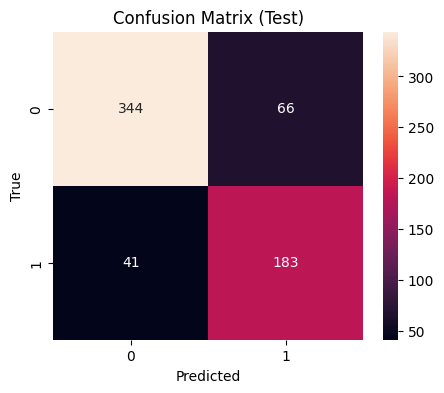

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
logits = model(data.x, data.edge_index)
preds  = logits.argmax(dim=1)

mask = (data.test_mask) & (data.y != -1)
y_true, y_pred = data.y[mask].cpu(), preds[mask].cpu()

print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 🕵️‍♂️ Интерпретация предсказаний с **GNNExplainer**
Выберем произвольный корректно классифицированный узел из тестовой выборки и посмотрим, какие рёбра и признаки были наиболее важны для модели.

## 💾 Сохранение обученной модели

In [ ]:
MODEL_PATH = Path('./checkpoints/gcn_model.pt')
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f'Модель сохранена в {MODEL_PATH.resolve()}')

Модель сохранена в /Users/a1234/Fraud/gnn/checkpoints/gcn_model.pt
